In [35]:
import numpy as np
import pandas as pd
import os
import re

# Data Prep for Model

In [36]:
state_level_df = pd.read_csv('data/cln/selected_states_real_sir.csv')
state_level_df[['state','population']].drop_duplicates()

state_level_df['standardized_date'] = pd.to_datetime(state_level_df['standardized_date'])
start_date_df = state_level_df.groupby(['state'],as_index = False).agg({'standardized_date':'min'})
start_date_df.columns = ['state','start_date']

state_level_df = pd.merge(state_level_df,start_date_df)
state_level_df['day'] = state_level_df['standardized_date'] - state_level_df['start_date']
state_level_df['day'] = state_level_df['day'].apply(lambda x : x.days)
state_level_df[state_level_df['day'] == 0]

,state,standardized_date,# Infected,# Deaths,total_number_of_days,population,# Susceptible,start_date,day
0,CA,2020-02-21,10.0,0.0,46,37253956,37253946.0,2020-02-21,0
47,CT,2020-03-14,20.0,0.0,24,3574097,3574077.0,2020-03-14,0
72,FL,2020-03-09,14.0,2.0,29,18801310,18801296.0,2020-03-09,0
102,IL,2020-03-09,13.0,0.0,29,12830632,12830619.0,2020-03-09,0
132,LA,2020-03-11,13.0,0.0,27,4533372,4533359.0,2020-03-11,0
160,MA,2020-03-08,22.0,0.0,30,6547629,6547607.0,2020-03-08,0
191,MI,2020-03-12,12.0,0.0,26,9883640,9883628.0,2020-03-12,0
218,NY,2020-03-04,11.0,0.0,34,19378102,19378091.0,2020-03-04,0
253,WA,2020-03-01,11.0,1.0,37,6724540,6724529.0,2020-03-01,0


In [37]:
state_level_df.columns=['Region name', 'date','# Infected','# Removed', 'total_number_of_days', 
                        'population','# Susceptible','start_date','day']
test_data = state_level_df[['Region name', 'date','# Infected','# Removed','# Susceptible','day']].copy()

test_data.head(3)

,Region name,date,# Infected,# Removed,# Susceptible,day
0,CA,2020-02-21,10.0,0.0,37253946.0,0
1,CA,2020-02-22,10.0,0.0,37253946.0,1
2,CA,2020-02-23,10.0,0.0,37253946.0,2


In [38]:
total_day_state = state_level_df[['Region name', 'total_number_of_days']].drop_duplicates()
total_day_state

,Region name,total_number_of_days
0,CA,46
47,CT,24
72,FL,29
102,IL,29
132,LA,27
160,MA,30
191,MI,26
218,NY,34
253,WA,37


# Model Starts here


In [39]:
from src.eval_model import *
from src.SIR import sir, dynamic_sim_sir, dynamic_sim_sir_df

# SIR: Find best $I_0$, beta, gamma 

- Optimize the SIR model first
- Using the first 15 day's of data, rest days will be used for evaluation
- Allow inital infected number of be adjust up

In [40]:
# specify range

I_adjust_range = np.array([0.8, 1, 1.2, 1.5, 1.75, 2]) # I0 = I * I_range_adjust
beta_range = np.arange(1e-8, 1.1e-7, 1e-9)
# beta_decay = np.arange (1e-2,0.2, 1e-2)
# beta_decay_start_day = np.arange (10,20,1)
beta_decay = [1e-3, 1e-2,0.1]
beta_decay_start_day = [10,15]
gamma_range = [1/x for x in range(4, 24, 4)]

def print_range(txt, x):
    print(txt + ' : ' + str(min(x)) + ' - ' + str(max(x)) + ' (' + str(len(x)) + ')')

print_range('# Infected Adjustment', I_adjust_range)
print_range('beta', beta_range)
print_range('beta_decay', beta_decay)
print_range('beta_decay_start_day', beta_decay_start_day)
print_range('gamma', gamma_range)
print_range('1/gamma', [1/x for x in gamma_range])
print('# Grids: ' + str(len(beta_range)*len(gamma_range)*len(I_adjust_range)))

# Infected Adjustment : 0.8 - 2.0 (6)
beta : 1e-08 - 1.0900000000000006e-07 (100)
beta_decay : 0.001 - 0.1 (3)
beta_decay_start_day : 10 - 15 (2)
gamma : 0.05 - 0.25 (5)
1/gamma : 4.0 - 20.0 (5)
# Grids: 3000


In [41]:
I_adjust_range_v, beta_range_v, beta_decay_v, beta_decay_start_day_v, gamma_v = np.meshgrid(
    I_adjust_range,\
    beta_range, \
    beta_decay,\
    beta_decay_start_day,\
    gamma_range,\
    sparse = False)

Grid = pd.DataFrame({
    'I_adjust':I_adjust_range_v.flatten(),
    'beta': beta_range_v.flatten(),
    'beta_decay': beta_decay_v.flatten(),
    'beta_decay_start_day': beta_decay_start_day_v.flatten(),
    'gamma':gamma_v.flatten()
})

In [42]:
Grid.shape

(18000, 5)

In [43]:
# get the day 0's number

DAY_0 = test_data[test_data['day'] == 0].copy()

DAY_0['N'] = DAY_0['# Infected'] + DAY_0['# Susceptible'] + DAY_0['# Removed']

DAY_0

,Region name,date,# Infected,# Removed,# Susceptible,day,N
0,CA,2020-02-21,10.0,0.0,37253946.0,0,37253956.0
47,CT,2020-03-14,20.0,0.0,3574077.0,0,3574097.0
72,FL,2020-03-09,14.0,2.0,18801296.0,0,18801312.0
102,IL,2020-03-09,13.0,0.0,12830619.0,0,12830632.0
132,LA,2020-03-11,13.0,0.0,4533359.0,0,4533372.0
160,MA,2020-03-08,22.0,0.0,6547607.0,0,6547629.0
191,MI,2020-03-12,12.0,0.0,9883628.0,0,9883640.0
218,NY,2020-03-04,11.0,0.0,19378091.0,0,19378102.0
253,WA,2020-03-01,11.0,1.0,6724529.0,0,6724541.0


In [44]:
def get_vetcor_beta(p_original_beta,p_decay, p_start_day, p_total_day):
    p_start_day=int(p_start_day)
    p_total_day= int(p_total_day)
    new_beta_v=[]
    if p_start_day>p_total_day:
        return [p_original_beta]*p_total_day
    else:
        for day in range(p_start_day):
            new_beta_v.append(p_original_beta)
        for day in range(p_start_day,p_total_day):
            new_beta_v.append(new_beta_v[-1]*(1-p_decay))
        return new_beta_v
        

In [45]:
# grid search for each region

region_var = 'Region name'
n_days_eval = 5 # carve out 5 days for back test

for region in test_data[region_var].unique():
    
    print(region)
    
    simulation_results = pd.DataFrame()
    
    for index, row in Grid.iterrows():
    
        # use part of days to do grid search
        n_days = total_day_state.loc[total_day_state[region_var] == region, 
                                 'total_number_of_days'].tolist()[0] - n_days_eval
        
        # Get parameter from Grid
        i_adjust = row['I_adjust']
        gamma = row['gamma']
        beta_vec = get_vetcor_beta(row['beta'], row['beta_decay'], row['beta_decay_start_day'],n_days)

        # fixed
        N =  DAY_0.loc[DAY_0[region_var] == region,'N'].tolist()[0]
        R =  DAY_0.loc[DAY_0[region_var] == region,'# Removed'].tolist()[0]

        # adjust I
        I =  int(DAY_0.loc[DAY_0[region_var] == region,'# Infected'].tolist()[0] * i_adjust)

        # back calculcate S
        S = N - I - R

        report = dynamic_sim_sir_df(S, I, R, gamma, 0, beta_vec, n_days)
        report[region_var] = region

        # include parameter setting
        report['beta'] = row['beta']
        report['beta_decay'] = row['beta_decay']
        report['beta_decay_start_day'] = row['beta_decay_start_day']
        report['gamma'] = gamma
        report['I0'] = I

        # append
        simulation_results = simulation_results.append(report)
    
    simulation_results = pd.merge(simulation_results, test_data, on = [region_var, 'day'])
    
    print(simulation_results.shape)

    simulation_results.to_csv('result/sir_decay/grid/' + region + '.csv', index = False)


CA
(756000, 14)
CT
(360000, 14)
FL
(450000, 14)
IL
(450000, 14)
LA
(414000, 14)
MA
(468000, 14)
MI
(396000, 14)
NY
(540000, 14)
WA
(594000, 14)


In [46]:
best_param = pd.DataFrame()
grid_path = 'result/sir_decay/grid/'

for path in os.listdir(grid_path):
    
    if re.findall(".csv", path):
    
        region = re.sub(".csv", "", path)
    
        data = pd.read_csv(grid_path + path)
    
        data = data.groupby(['beta', 'beta_decay','beta_decay_start_day','gamma', 'I0']).\
        apply(lambda x: gen_Metrics(x, 'infected', '# Infected')).\
        reset_index().\
        drop('level_5', axis = 1)
    
        tmp = data.loc[data['SSE'].idxmin()].copy() ## min
    
        tmp[region_var] = region
    
        best_param = best_param.append(tmp)

best_param.to_excel(grid_path + '_best_param.xlsx', index = False)

In [47]:
best_param
# 3-30

,I0,Region name,SAE,SAPE,SSE,SSPE,beta,beta_decay,beta_decay_start_day,gamma
11249,22.0,WA,10333.765209,9.998462,5.174664e+06,4.313759,7.200000e-08,0.010,10.0,0.250000
17447,40.0,CT,1358.774895,4.120061,2.226296e+05,2.619344,1.060000e-07,0.100,15.0,0.083333
8402,14.0,MI,3263.452638,4.108437,9.339605e+05,1.995364,5.600000e-08,0.100,10.0,0.050000
414,8.0,CA,6798.878224,16.680717,3.934580e+06,19.703527,1.200000e-08,0.001,15.0,0.250000
2676,11.0,FL,2843.907188,5.508201,5.850566e+05,1.956605,2.400000e-08,0.100,15.0,0.062500
4298,15.0,IL,2390.439231,2.754995,5.058301e+05,0.450694,3.300000e-08,0.100,15.0,0.062500
15923,26.0,LA,6418.980549,7.193137,3.116883e+06,3.367696,9.800000e-08,0.010,10.0,0.125000
12867,33.0,MA,5075.547605,6.471562,2.045743e+06,2.741735,8.100000e-08,0.010,10.0,0.250000
3571,11.0,NY,18653.925881,4.632254,2.925116e+07,1.817424,2.900000e-08,0.100,15.0,0.050000


# Final Model

### SIR model

In [48]:
region_var = 'Region name'
n_days_fit = 30 
best_param_1 = pd.read_excel('result/sir_decay/grid/_best_param.xlsx')
final_result = pd.DataFrame()

for region in DAY_0[region_var]:
    
    # fixed
    N =  DAY_0.loc[DAY_0[region_var] == region,'N'].tolist()[0]
    R =  DAY_0.loc[DAY_0[region_var] == region,'# Removed'].tolist()[0]
    
    # best SIR 
    I = best_param_1.loc[best_param_1[region_var] == region, 'I0'].tolist()[0]
    beta = best_param_1.loc[best_param_1[region_var] == region, 'beta'].tolist()[0]
    beta_decay = best_param_1.loc[best_param_1[region_var] == region, 'beta_decay'].tolist()[0]
    beta_decay_start_day = best_param_1.loc[best_param_1[region_var] == region, 'beta_decay_start_day'].tolist()[0]
    gamma = best_param_1.loc[best_param_1[region_var] == region, 'gamma'].tolist()[0]
                
    S = N - I - R
    
    # use all available days
    n_days = total_day_state.loc[total_day_state[region_var] == region, 
                                 'total_number_of_days'].tolist()[0]
    
    beta_vec = get_vetcor_beta(beta, beta_decay, beta_decay_start_day,n_days)
            
    report = dynamic_sim_sir_df(S, I, R, gamma, 0, beta_vec, n_days)
    report[region_var] = region
                
    # append
    report['day'] = report.index.astype(int)
    final_result = final_result.append(report)


final_result.to_excel('result/sir_decay/final_sir_model.xlsx', index = False)

# Plot the curve

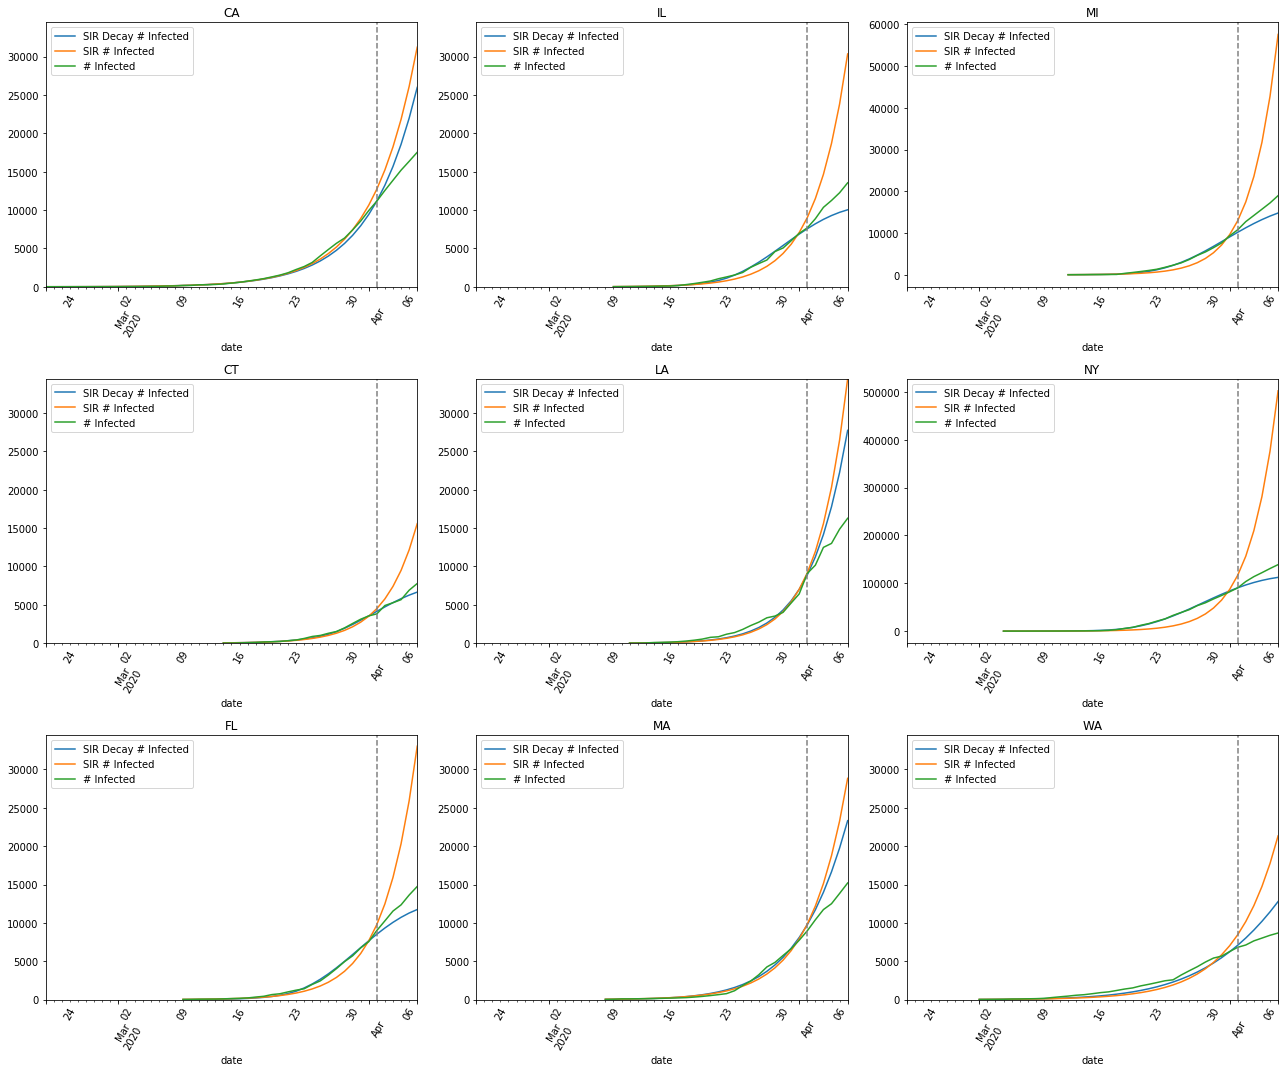

In [55]:
final_result_sir = pd.read_excel('result/sir/final_sir_model.xlsx')\
[['susceptible', 'infected', 'recovered', 'Region name', 'day']].\
rename(columns = {'susceptible':'SIR # Susceptible',
                 'infected':'SIR # Infected',
                 'recovered':'SIR # Removed'})

final_result_sir_decay = pd.read_excel('result/sir_decay/final_sir_model.xlsx')\
[['susceptible', 'infected', 'recovered', 'Region name', 'day']].\
rename(columns = {'susceptible':'SIR Decay # Susceptible',
                 'infected':'SIR Decay # Infected',
                 'recovered':'SIR Decay # Removed'})

final = pd.merge(final_result_sir, final_result_sir_decay)
final = pd.merge(final, test_data)

min_date = min(final['date'])
max_date = max(final['date'])

min_y = min(min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR Decay # Infected']),
            min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR # Infected']), 
            min(final.loc[final['Region name'].isin(['NY', 'MI']) == False, '# Infected']))

max_y = max(max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR Decay # Infected']), 
            max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, 'SIR # Infected']), 
            max(final.loc[final['Region name'].isin(['NY', 'MI']) == False, '# Infected']))
nrow = 3
ncol = 3

x = np.arange(0, nrow, 1)
y = np.arange(0, ncol, 1)
xx, yy = np.meshgrid(x, y)    
num = 0 

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = nrow, ncols = ncol, figsize = (ncol * 6, nrow * 5))

for region in final['Region name'].unique():
    
    
    region_data = final[final['Region name'] == region].copy()
    
    # find the last day for gridsearch
    end_day = total_day_state.loc[total_day_state['Region name'] == region, "total_number_of_days"].tolist()[0] - 5
   
    end_date = pd.to_datetime(region_data.loc[region_data['day'] == end_day, "date"].tolist()[0])
    
    # axis set up 
    x = xx.flatten()[num]
    y = yy.flatten()[num]
            
    # plot
    tmp = region_data[['date', 'SIR Decay # Infected', 'SIR # Infected', '# Infected']].copy()
    
    tmp['date'] = tmp['date'].apply(lambda x: pd.to_datetime(x))
    
    tmp = tmp.set_index('date')
    
    if region in ['NY', 'MI']:
        ax = tmp.plot(ax = axes[x, y], title = region, rot = 60, xlim = (min_date, max_date))
    else:
        ax = tmp.plot(ax = axes[x, y], title = region, rot = 60, xlim = (min_date, max_date), ylim = (min_y, max_y))

    ax.axvline(end_date, color="grey", linestyle="--")
    
    num += 1

plt.tight_layout()
plt.savefig('result/sir_decay//final_fitted_sir_decay.png', dpi = 220)